In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Training
---

## Centralized model

Load data from a chosen machine.

In [3]:
from utils import timesteps, train_percentage, getClientData, getTrainAndTestData

machine = 'Compressore 3'
data = getClientData(machine)
X_train, y_train, _, _, _ = getTrainAndTestData(data)

Load and train the model.

In [4]:
from models import ncp
from utils import batch_size, num_epochs

ncp_c, _ = ncp()
hist_cen = ncp_c.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, verbose=1)

Epoch 1/50
193/193 [==============================] - 4s 12ms/step - loss: 0.2687 - mse: 0.2687
Epoch 2/50
193/193 [==============================] - 2s 12ms/step - loss: 0.1129 - mse: 0.1129
Epoch 3/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0948 - mse: 0.0948
Epoch 4/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0840 - mse: 0.0840
Epoch 5/50
193/193 [==============================] - 2s 13ms/step - loss: 0.0798 - mse: 0.0798
Epoch 6/50
193/193 [==============================] - 2s 13ms/step - loss: 0.0648 - mse: 0.0648
Epoch 7/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0498 - mse: 0.0498
Epoch 8/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0406 - mse: 0.0406
Epoch 9/50
193/193 [==============================] - 2s 13ms/step - loss: 0.0360 - mse: 0.0360
Epoch 10/50
193/193 [==============================] - 2s 12ms/step - loss: 0.0326 - mse: 0.0326
Epoch 11/50
193/193 [==================

## Federated model

Load the model and its weights.

In [5]:
ncp_f, _ = ncp()
weights_ncp_npz = np.load("weights_ncp.npz")
weights_ncp = [weights_ncp_npz[f"arr_{i}"] for i in range(len(weights_ncp_npz.files))]
ncp_f.set_weights(weights_ncp)

# Comparison
---

In [6]:
train_size = X_train.shape[0]   # Number of training samples
timestamps = data.index.values  # Timestamps

measurements = [
  'Current (A)',
  'CosPhi (Units)',
  'Energy Consumption (kWh)',
  'Reactive Energy (VARh)',
  'Voltage (V)']

Load test data from all machines.

In [7]:
machines = ["Compressore 1", "Compressore 2", "Compressore 3", "Compressore 4"]

data = {}
for machine in machines:
  data[machine] = getClientData(machine)

X_test = {}
y_test = {}
scaler = {}

for machine in machines:
    _, _, X_test[machine], y_test[machine], scaler[machine] = getTrainAndTestData(data[machine])

Make predictions with the **centralized model**.

In [8]:
y_cen = {}
for machine in machines:
    y_cen[machine] = ncp_c.predict(X_test[machine])

26/26 [==============================] - 0s 3ms/step


Make predictions with the **federated model**.

In [9]:
y_fed = {}
for machine in machines:
    y_fed[machine] = ncp_f.predict(X_test[machine])

26/26 [==============================] - 0s 4ms/step


Compute the average MSE for each test dataset.

In [10]:
mse_cen = []
mse_fed = []

for i in range(len(machines)):
    mse_cen.append(np.mean(np.square(y_test[machines[i]] - y_cen[machines[i]])))
    mse_fed.append(np.mean(np.square(y_test[machines[i]] - y_fed[machines[i]])))

print("MSE Centralized")
print(mse_cen)
print("MSE Federated")
print(mse_fed)

MSE Centralized
[0.006929355346093554, 0.01433024445536952, 0.0161923686025133, 0.021589934193233618]
MSE Federated
[0.005503972957410262, 0.007915506217056688, 0.01358776172718312, 0.014789443061964365]


Plot the average MSEs into an histogram.

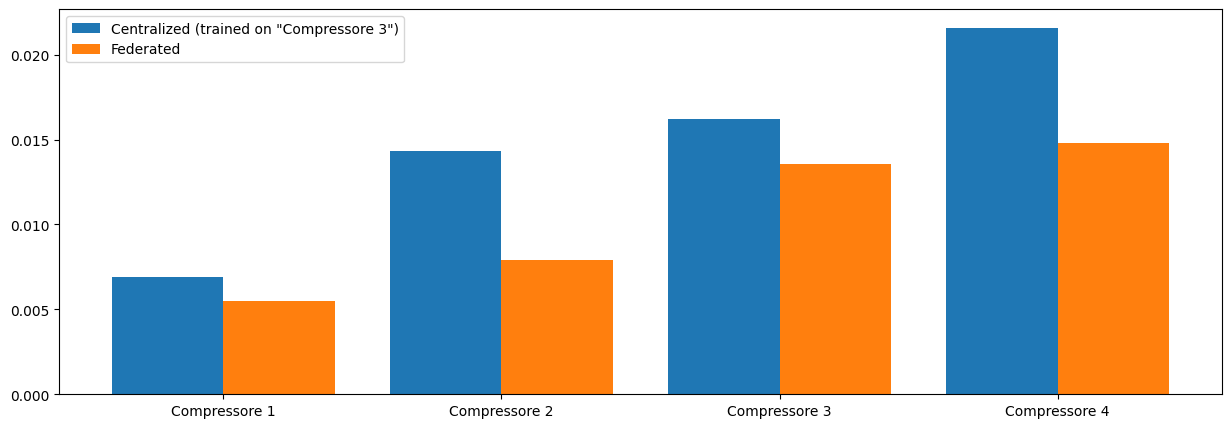

In [12]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(machines)) - 0.2, mse_cen, 0.4, label = 'Centralized (trained on "Compressore 3")') 
plt.bar(np.arange(len(machines)) + 0.2, mse_fed, 0.4, label = 'Federated') 
plt.xticks(np.arange(len(machines)), machines) 
plt.legend() 
plt.show() 